# Objective

Predict the age of user given the reviews and product information for women's e-commerce clothing.

In [184]:
%matplotlib inline
import pandas as pd
import sys
import re
import string
import os
import numpy as np
import codecs
from scipy.spatial import distance
from nltk.corpus import stopwords
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding
import matplotlib.pyplot as plt
import itertools
from collections import Counter
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
init_notebook_mode(connected=True)
from keras.layers import LSTM

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from display_confusion_matrix import display_confusion_matrix

In [3]:
stop = set(stopwords.words('english'))

## Read in data

In [4]:
df = pd.read_csv("/Users/deena/Documents/Summer/NLP/FinalProject/Womens Clothing E-Commerce Reviews.csv", encoding='iso-8859-1')

In [5]:
sum(df['Review Text'].isnull().values)

845

In [6]:
len(df['Review Text'])

23486

In [7]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [8]:
# Remove null reviews and null Department Name
df = df.dropna(subset=['Review Text', 'Division Name'], how='any').reset_index()
len(df)

22628

In [146]:
data = [go.Bar(
            x=df.groupby('Age').count().reset_index()['Age'],
            y=df.groupby('Age').count().reset_index()['index']
    )]

layout = dict(title='Distribution of Age', showlegend=False,
              xaxis=dict(
        title='Age'),
              yaxis=dict(
        title='Count'
              ))

figure = dict(data=data, layout=layout)
iplot(figure)

In [75]:
df.loc[df['Age'] < 50, 'age_group'] = 1
#df.loc[(df['Age'] >= 25) & (df['Age'] < 35), 'age_group'] = 2
#df.loc[(df['Age'] >= 35) & (df['Age'] < 40), 'age_group'] = 3
#df.loc[(df['Age'] >= 45) & (df['Age'] < 55), 'age_group'] = 4
df.loc[df['Age'] >= 50, 'age_group'] = 2

In [226]:
data = [go.Bar(
            #x=df.groupby('age_group').count().reset_index()['age_group'],
            y=df.groupby('age_group').count().reset_index()['index'],
            x=['<50 years', '>=50 years'],
            text=df.groupby('age_group').count().reset_index()['index'],
            textposition = 'outside',
    )]

layout = dict(title='Distribution of age group', showlegend=False,
              
              )

figure = dict(data=data, layout=layout)
iplot(figure)

In [148]:
df[['Age', 'Review Text']].head()

,Age,Review Text
0,33,Absolutely wonderful - silky and sexy and comf...
1,34,Love this dress! it's sooo pretty. i happene...
2,60,I had such high hopes for this dress and reall...
3,50,"I love, love, love this jumpsuit. it's fun, fl..."
4,47,This shirt is very flattering to all due to th...


## Functions for processing reviews

In [17]:
def load_glove(filename):
    """
    Read all lines from the indicated file and return a dictionary
    mapping word:vector where vectors are of numpy `array` type.
    GloVe file lines are of the form:

    the 0.418 0.24968 -0.41242 0.1217 ...

    So split each line on spaces into a list; the first element is the word
    and the remaining elements represent factor components. The length of the vector
    should not matter; read vectors of any length.
    """
    d = {}
    with open(filename, 'r') as f:
        text = f.readlines()
        for line in text:
            l = line.split(' ')
            d[l[0]] = []
            for i in range(1,len(l)):
                d[l[0]].append(float(l[i].strip()))
            d[l[0]] = np.array(d[l[0]])

    return d

In [18]:
# Function to clean reviews and get words
def words(text):
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words = nopunct.split(' ')
    words = [w for w in words if len(w) > 2]
    words = [w.lower() for w in words]
    goodwords = [w for w in words if w not in stop]

    return goodwords

In [19]:
# Create word embedding from text
def doc2vec(text, gloves):
    """
    Return the word vector centroid for the text. Sum the word vectors
    for each word and then divide by the number of words. Ignore words
    not in gloves.
    """
    word = words(text)
    array_sum = np.zeros(len(list(gloves.values())[0]))
    cnt = 0
    for w in word:
        if w in gloves:
            array_sum = np.add(gloves[w], array_sum)
            cnt += 1

    if cnt != 0:
        return array_sum/cnt
    else:
        return array_sum

In [20]:
# Confusion Matrix plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Word Clouds for the two age group reviews

In [228]:
# Group 1
#grp1 = ' '.join([' '.join(words(review)) for review in  df[df.age_group == 1]['Title_review']])
grp2 = ' '.join([' '.join(words(review)) for review in  df[df.age_group == 2]['Title_review']])

In [229]:
text_file = open("grp2.txt", "w")
text_file.write(grp2)
text_file.close()

## Feature Engineering

In [89]:
df['Title_review'] = df['Title'].fillna('') + ' ' + df['Review Text']

In [90]:
# Label encoding Categorical columns

lb_make = LabelEncoder()
df['division_name_encoded'] = lb_make.fit_transform(df['Division Name'])
df['dept_name_encoded'] = lb_make.fit_transform(df['Department Name'])
df['class_name_encoded'] = lb_make.fit_transform(df['Class Name'])

In [91]:
# Create embeddings of review text

glove = load_glove('./glove.6B/glove.6B.200d.txt')
embedding = [doc2vec(review, glove) for review in  df['Title_review']]

In [92]:
df.head()

,index,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Sentiment,age_group,Title_review,division_name_encoded,dept_name_encoded,class_name_encoded
0,0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,1.0,1.0,Absolutely wonderful - silky and sexy and com...,2,2,5
1,1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,1.0,1.0,Love this dress! it's sooo pretty. i happen...,0,1,3
2,2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,0.0,2.0,Some major design flaws I had such high hopes ...,0,1,3
3,3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,1.0,2.0,"My favorite buy! I love, love, love this jumps...",1,0,13
4,4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,1.0,1.0,Flattering shirt This shirt is very flattering...,0,4,0


In [93]:
features = []
for i in range(0, len(df)):
    features.append(embedding[i] + [df['division_name_encoded'][i] +  df['Clothing ID'][i] 
                    + df['dept_name_encoded'][i] + df['class_name_encoded'][i] + df['Rating'][i]])

## Classification Model to predict Rating

In [157]:
# Divide into train and test
X_train, X_test, Y_train, Y_test = train_test_split(embedding,
                                          df['age_group'], test_size = 0.2, random_state=42)

In [175]:
# ------------ Random Forest

forest = RandomForestClassifier(n_estimators = 5, min_samples_leaf = 2)
forest = forest.fit(X_train, Y_train)

predictions = forest.predict(X_test)


print("Accuracy: ", accuracy_score(Y_test, predictions))

Accuracy:  0.6480335837384004


In [153]:
print("Distribution for Test:", Counter(Y_test))
print("Distribution for Predictions:", Counter(predictions))

Distribution for Test: Counter({5: 2515, 4: 978, 3: 547, 2: 329, 1: 157})
Distribution for Predictions: Counter({5: 4101, 4: 218, 3: 203, 1: 2, 2: 2})


Confusion matrix, without normalization
[[2727  473]
 [1120  206]]


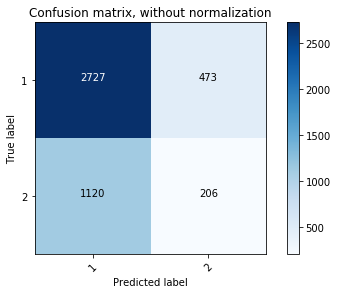

In [176]:
cnf_matrix = confusion_matrix(Y_test, predictions)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2],
                      title='Confusion matrix, without normalization')

In [162]:
# ------------ Logistic Regression

logisticRegr = LogisticRegression(C=10, penalty = 'l2')
logisticRegr.fit(X_train, Y_train)

predictions = logisticRegr.predict(X_test)

print("Accuracy: ", accuracy_score(Y_test, predictions))


Accuracy:  0.7012814847547504


In [68]:
print("Distribution for Test:", Counter(Y_test))
print("Distribution for Predictions:", Counter(predictions))

Distribution for Test: Counter({1.0: 3200, 2.0: 1326})
Distribution for Predictions: Counter({1.0: 4481, 2.0: 45})


Confusion matrix, without normalization
[[3144   56]
 [1296   30]]


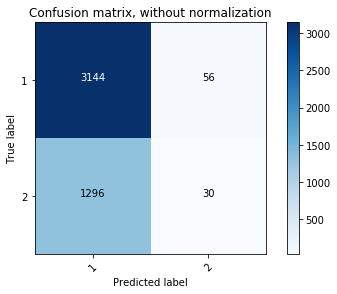

In [164]:
cnf_matrix = confusion_matrix(Y_test, predictions)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2],
                      title='Confusion matrix, without normalization')

## Neural Networks using Keras

In [209]:
# Divide into train and test
x_train, x_test, y_train, y_test = train_test_split(embedding,
                                          df['age_group'], test_size = 0.2, random_state=42)

In [210]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test,)

In [219]:
print('Building model...')

model = Sequential()

model.add(Dense(input_dim=200, output_dim=100, activation='sigmoid'))
#model.add(Dense(input_dim=40, output_dim=10, activation='sigmoid'))
model.add(Dense(output_dim=3, activation='softmax'))

print("Training model...")

model.compile(
              loss='binary_crossentropy', # TODO: What should the loss function be?
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 5

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=True,
                    validation_split=0.1)

Building model...
Training model...


/Users/deena/anaconda/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(input_dim=200, activation="sigmoid", units=100)`

/Users/deena/anaconda/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=3)`



Train on 16291 samples, validate on 1811 samples
Epoch 1/5
16291/16291 [==============================] - 3s 184us/step - loss: 0.4046 - acc: 0.8049 - val_loss: 0.3949 - val_acc: 0.8130
Epoch 2/5
16291/16291 [==============================] - 1s 62us/step - loss: 0.3984 - acc: 0.8066 - val_loss: 0.3919 - val_acc: 0.8115
Epoch 3/5
16291/16291 [==============================] - 1s 71us/step - loss: 0.3973 - acc: 0.8064 - val_loss: 0.3914 - val_acc: 0.8126
Epoch 4/5
16291/16291 [==============================] - 1s 52us/step - loss: 0.3959 - acc: 0.8068 - val_loss: 0.3907 - val_acc: 0.8126
Epoch 5/5
16291/16291 [==============================] - 1s 47us/step - loss: 0.3954 - acc: 0.8068 - val_loss: 0.3902 - val_acc: 0.8126


In [220]:
loss, accuracy = model.evaluate(x_test, y_test,
                                batch_size=batch_size, 
                                verbose=True)

print(f'Test score: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

4526/4526 [==============================] - 0s 22us/step
Test score: 0.399
Test accuracy: 0.804
